# Stage 1: Data Preparation & Exploration

**Objectives**:
- Load and explore the leukocyte dataset
- Verify class distribution (500 images per class)
- Perform exploratory data analysis (EDA)
- Create stratified train/validation/test split
- Save split configuration for reproducibility

**Output**: `data_split.csv` with file paths and split labels

## 1. Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)

## 2. Load Dataset

In [2]:
# Define dataset path
dataset_path = Path('../Dataset and Notebook-20251115/dataset_leukocytes')

# Verify path exists
assert dataset_path.exists(), f"Dataset path does not exist: {dataset_path}"

print(f"Dataset path: {dataset_path}")
print(f"Dataset exists: {dataset_path.exists()}")

Dataset path: ../Dataset and Notebook-20251115/dataset_leukocytes
Dataset exists: True


In [3]:
# Get all image files and create dataframe
def create_dataset_dataframe(base_path):
    """
    Create a dataframe with image paths and labels
    """
    data = []
    
    # Expected classes
    classes = ['basophil', 'eosinophil', 'lymphocyte', 'monocyte', 'neutrophil']
    
    for class_name in classes:
        class_path = base_path / class_name
        if class_path.exists():
            # Get all jpg files
            image_files = list(class_path.glob('*.jpg'))
            
            for img_path in image_files:
                data.append({
                    'filepath': str(img_path),
                    'filename': img_path.name,
                    'label': class_name
                })
    
    return pd.DataFrame(data)

# Create dataframe
df = create_dataset_dataframe(dataset_path)

print(f"Total images: {len(df)}")
print(f"\nFirst few rows:")
df.head()

Total images: 2500

First few rows:


,filepath,filename,label
0,../Dataset and Notebook-20251115/dataset_leuko...,BA_883452.jpg,basophil
1,../Dataset and Notebook-20251115/dataset_leuko...,BA_977935.jpg,basophil
2,../Dataset and Notebook-20251115/dataset_leuko...,BA_878384.jpg,basophil
3,../Dataset and Notebook-20251115/dataset_leuko...,BA_879878.jpg,basophil
4,../Dataset and Notebook-20251115/dataset_leuko...,BA_23839.jpg,basophil


## 3. Exploratory Data Analysis (EDA)

Class distribution:
label
basophil      500
eosinophil    500
lymphocyte    500
monocyte      500
neutrophil    500
Name: count, dtype: int64

Expected: 500 images per class
Total: 2500 images


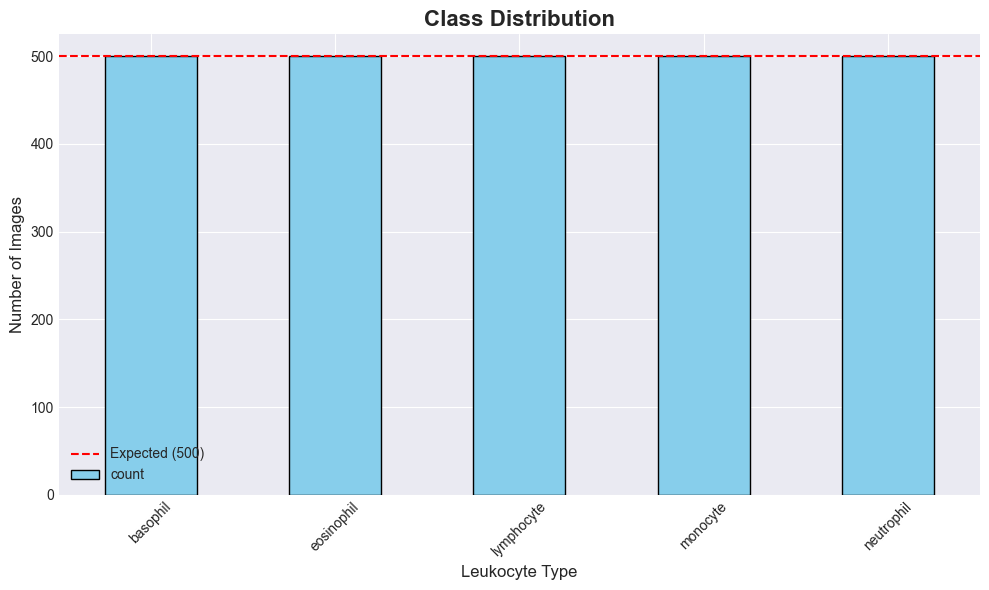

In [4]:
# Verify class distribution
class_counts = df['label'].value_counts().sort_index()
print("Class distribution:")
print(class_counts)
print(f"\nExpected: 500 images per class")
print(f"Total: {len(df)} images")

# Visualize class distribution
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Class Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Leukocyte Type', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45)
plt.axhline(y=500, color='r', linestyle='--', label='Expected (500)')
plt.legend()
plt.tight_layout()
plt.savefig('../outputs/figures/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [5]:
# Analyze image dimensions
def get_image_dimensions(filepath):
    """Get image dimensions"""
    with Image.open(filepath) as img:
        return img.size  # (width, height)

# Sample 100 random images to check dimensions
sample_df = df.sample(n=min(100, len(df)), random_state=SEED)
dimensions = [get_image_dimensions(fp) for fp in sample_df['filepath']]

widths = [d[0] for d in dimensions]
heights = [d[1] for d in dimensions]

print(f"Image dimension statistics (sample of {len(dimensions)}):")
print(f"Width  - Min: {min(widths)}, Max: {max(widths)}, Mean: {np.mean(widths):.2f}")
print(f"Height - Min: {min(heights)}, Max: {max(heights)}, Mean: {np.mean(heights):.2f}")

# Check if all images have same dimensions
unique_dims = set(dimensions)
print(f"\nUnique dimensions found: {len(unique_dims)}")
if len(unique_dims) <= 5:
    for dim in unique_dims:
        print(f"  {dim}")

Image dimension statistics (sample of 100):
Width  - Min: 360, Max: 366, Mean: 360.06
Height - Min: 363, Max: 369, Mean: 363.06

Unique dimensions found: 2
  (366, 369)
  (360, 363)


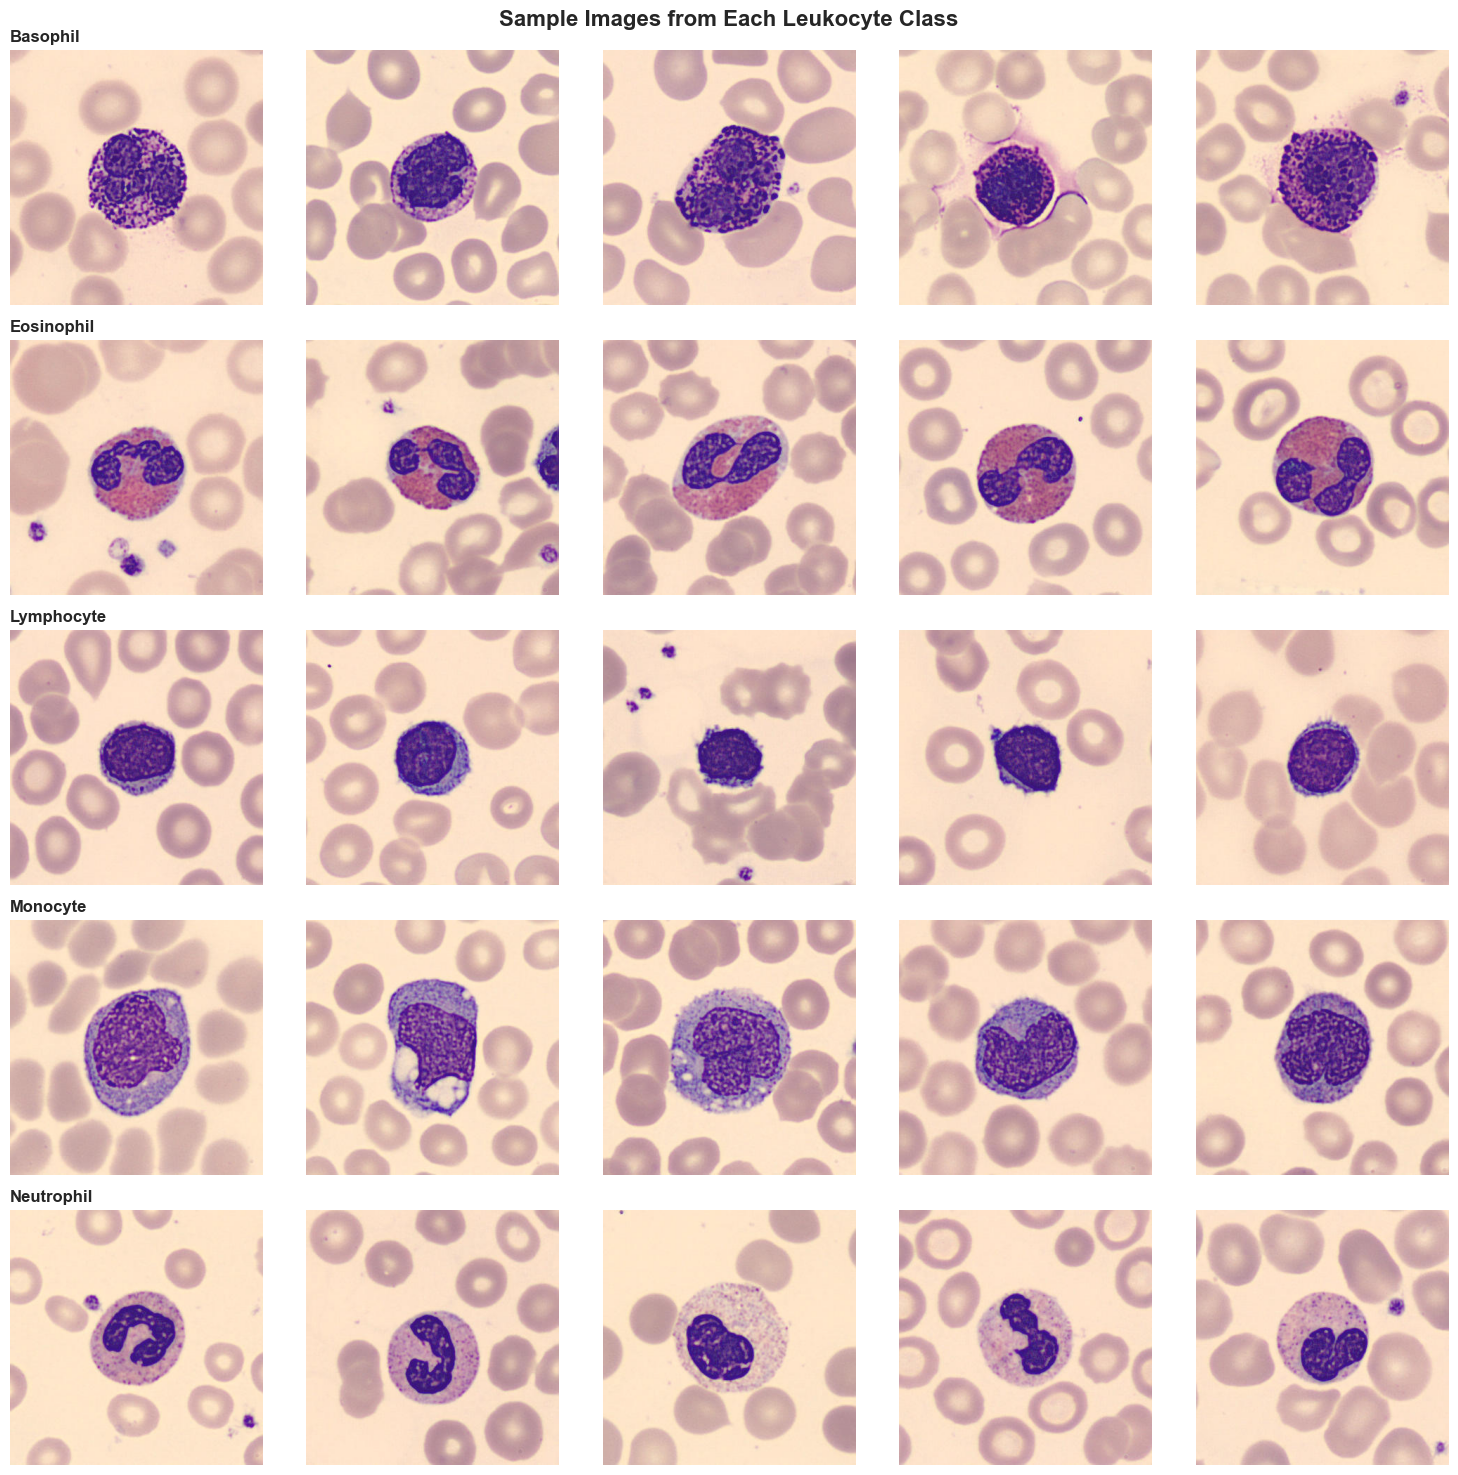

In [6]:
# Visualize sample images from each class
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
fig.suptitle('Sample Images from Each Leukocyte Class', fontsize=16, fontweight='bold')

classes = sorted(df['label'].unique())

for idx, class_name in enumerate(classes):
    # Get 5 random samples from this class
    class_samples = df[df['label'] == class_name].sample(n=5, random_state=SEED)
    
    for col, (_, row) in enumerate(class_samples.iterrows()):
        img = Image.open(row['filepath'])
        axes[idx, col].imshow(img)
        axes[idx, col].axis('off')
        
        if col == 0:
            axes[idx, col].set_title(class_name.capitalize(), fontsize=12, fontweight='bold', loc='left')

plt.tight_layout()
plt.savefig('../outputs/figures/sample_images.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Create Train/Validation/Test Split

In [7]:
# Define split ratios
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

print(f"Split ratios:")
print(f"  Train: {TRAIN_RATIO*100}%")
print(f"  Validation: {VAL_RATIO*100}%")
print(f"  Test: {TEST_RATIO*100}%")

# Perform stratified split
# First split: train vs (val + test)
train_df, temp_df = train_test_split(
    df,
    test_size=(VAL_RATIO + TEST_RATIO),
    stratify=df['label'],
    random_state=SEED
)

# Second split: val vs test
val_df, test_df = train_test_split(
    temp_df,
    test_size=TEST_RATIO / (VAL_RATIO + TEST_RATIO),
    stratify=temp_df['label'],
    random_state=SEED
)

# Add split column
train_df['split'] = 'train'
val_df['split'] = 'val'
test_df['split'] = 'test'

# Combine back
df_split = pd.concat([train_df, val_df, test_df], ignore_index=True)

print(f"\nSplit sizes:")
print(f"  Train: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"  Validation: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
print(f"  Test: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")
print(f"  Total: {len(df_split)}")

Split ratios:
  Train: 70.0%
  Validation: 15.0%
  Test: 15.0%

Split sizes:
  Train: 1750 (70.0%)
  Validation: 375 (15.0%)
  Test: 375 (15.0%)
  Total: 2500


Class distribution per split:
label  basophil  eosinophil  lymphocyte  monocyte  neutrophil
split                                                        
test         75          75          75        75          75
train       350         350         350       350         350
val          75          75          75        75          75


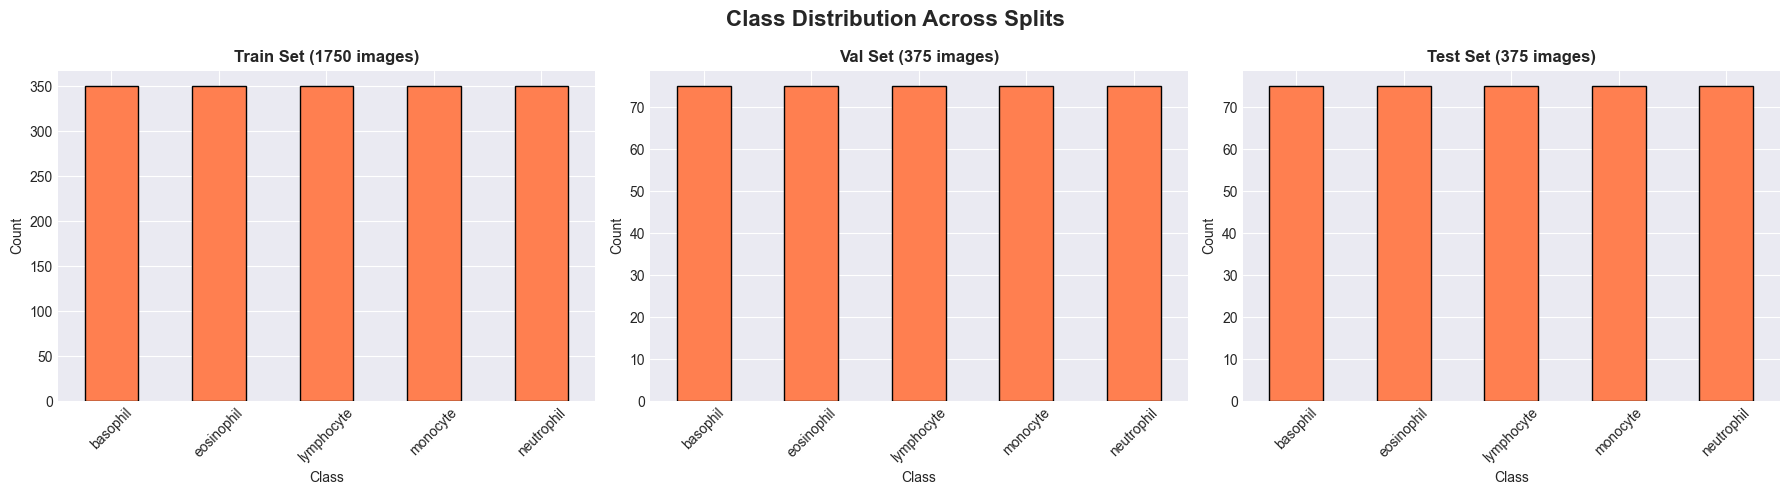

In [8]:
# Verify stratification - check class distribution in each split
print("Class distribution per split:")
split_distribution = df_split.groupby(['split', 'label']).size().unstack(fill_value=0)
print(split_distribution)

# Visualize split distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Class Distribution Across Splits', fontsize=16, fontweight='bold')

for idx, split in enumerate(['train', 'val', 'test']):
    split_data = df_split[df_split['split'] == split]['label'].value_counts().sort_index()
    split_data.plot(kind='bar', ax=axes[idx], color='coral', edgecolor='black')
    axes[idx].set_title(f'{split.capitalize()} Set ({len(df_split[df_split["split"] == split])} images)', 
                       fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Class', fontsize=10)
    axes[idx].set_ylabel('Count', fontsize=10)
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../outputs/figures/split_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Save Split Configuration

In [9]:
# Save to CSV
output_path = '../outputs/data_split.csv'
df_split.to_csv(output_path, index=False)
print(f"✓ Split configuration saved to: {output_path}")

# Verify saved file
df_verify = pd.read_csv(output_path)
print(f"\nVerification:")
print(f"  Rows in saved file: {len(df_verify)}")
print(f"  Columns: {list(df_verify.columns)}")
print(f"\nFirst few rows:")
print(df_verify.head())

✓ Split configuration saved to: ../outputs/data_split.csv

Verification:
  Rows in saved file: 2500
  Columns: ['filepath', 'filename', 'label', 'split']

First few rows:
                                            filepath       filename  \
0  ../Dataset and Notebook-20251115/dataset_leuko...  BNE_30848.jpg   
1  ../Dataset and Notebook-20251115/dataset_leuko...   MO_87762.jpg   
2  ../Dataset and Notebook-20251115/dataset_leuko...  EO_487696.jpg   
3  ../Dataset and Notebook-20251115/dataset_leuko...  MO_311939.jpg   
4  ../Dataset and Notebook-20251115/dataset_leuko...   EO_48767.jpg   

        label  split  
0  neutrophil  train  
1    monocyte  train  
2  eosinophil  train  
3    monocyte  train  
4  eosinophil  train  


## 6. Summary Statistics

In [10]:
print("="*60)
print("DATA PREPARATION SUMMARY")
print("="*60)
print(f"\nDataset Information:")
print(f"  Total images: {len(df_split)}")
print(f"  Number of classes: {df_split['label'].nunique()}")
print(f"  Classes: {sorted(df_split['label'].unique())}")
print(f"\nSplit Configuration:")
print(f"  Train: {len(train_df)} images ({len(train_df)/len(df_split)*100:.1f}%)")
print(f"  Validation: {len(val_df)} images ({len(val_df)/len(df_split)*100:.1f}%)")
print(f"  Test: {len(test_df)} images ({len(test_df)/len(df_split)*100:.1f}%)")
print(f"\nOutput Files:")
print(f"  ✓ {output_path}")
print(f"  ✓ ../outputs/figures/class_distribution.png")
print(f"  ✓ ../outputs/figures/sample_images.png")
print(f"  ✓ ../outputs/figures/split_distribution.png")
print(f"\n" + "="*60)
print("✓ Data preparation complete!")
print("Next: Proceed to 02_model_training.ipynb")
print("="*60)

DATA PREPARATION SUMMARY

Dataset Information:
  Total images: 2500
  Number of classes: 5
  Classes: ['basophil', 'eosinophil', 'lymphocyte', 'monocyte', 'neutrophil']

Split Configuration:
  Train: 1750 images (70.0%)
  Validation: 375 images (15.0%)
  Test: 375 images (15.0%)

Output Files:
  ✓ ../outputs/data_split.csv
  ✓ ../outputs/figures/class_distribution.png
  ✓ ../outputs/figures/sample_images.png
  ✓ ../outputs/figures/split_distribution.png

✓ Data preparation complete!
Next: Proceed to 02_model_training.ipynb
